In [9]:
# Manipulacion
import pandas as pd
import numpy as np

# Visualizaciones
import seaborn as sns
import matplotlib.pyplot as plt
import scikitplot as skplt

# Modelos y operaciones 
import sklearn

# Pipelines
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

# El XGBoost
from sklearn.ensemble import GradientBoostingClassifier 

# Evaluación de modelos
from sklearn import metrics # Evaluación de modelo
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve
from sklearn.metrics import precision_recall_curve

#regex
import re

#matplotlib
import matplotlib
import matplotlib.pyplot as plt

# Cargar modelos
import pickle 

# Shap
import shap

# Ocultar warnings
import warnings
warnings.filterwarnings('ignore')

In [10]:
# Leemos datos
xtrain = pd.read_parquet("../data/xtrain.parquet")
ytrain = pd.read_parquet("../data/ytrain.parquet")['fatality']
xtest = pd.read_parquet("../data/xtest.parquet")
ytest = pd.read_parquet("../data/ytest.parquet")['fatality']

In [11]:
# Cargamos modelo optimizado
# Para no tener que ejecutar, saltarse el fit y ejecutar a partir de aquí
with open('../models/LightGBM_pipeline.pickle', 'rb') as f:
    clf = pickle.load(f)

clf.best_params_

{'importance_type': 'split',
 'is_unbalance': True,
 'learning_rate': 0.05,
 'max_depth': -1,
 'n_estimators': 300,
 'num_leaves': 200,
 'objective': 'binary'}

In [12]:
#model = clf.fit(xtrain, ytrain)

In [13]:
# Generamos predicciones
ypred = clf.predict(xtest)
ypred_proba = clf.predict_proba(xtest)

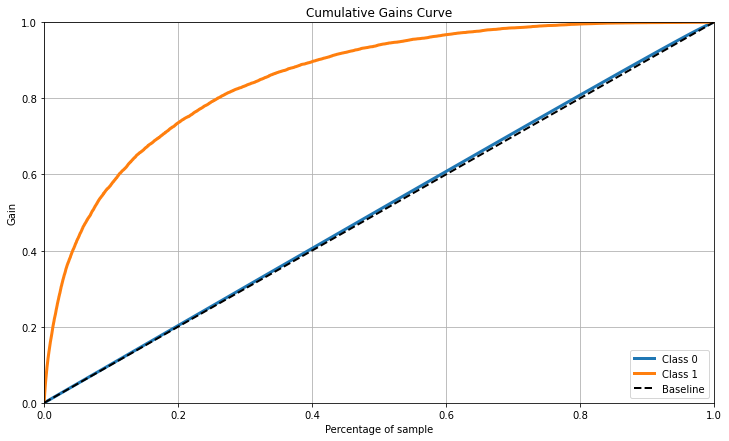

In [14]:
# Gain curve (curva de ganancia acumulada)
skplt.metrics.plot_cumulative_gain(ytest, ypred_proba, figsize=(12, 7));

In [15]:
# roc curve

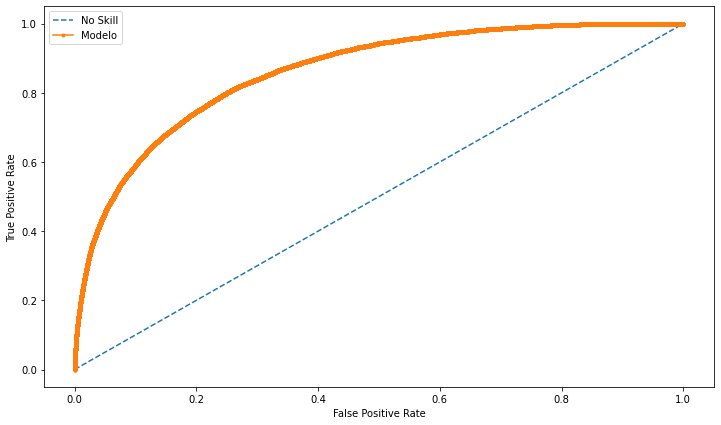

In [16]:
    # keep probabilities for the positive outcome only
    matplotlib.rcParams['figure.figsize'] = (12, 7)
    yhat = ypred_proba[:, 1]
    # calculate roc curves
    fpr, tpr, thresholds = roc_curve(ytest, yhat)
    # plot the roc curve for the model
    plt.plot([0,1], [0,1], linestyle='--', label='No Skill')
    plt.plot(fpr, tpr, marker='.', label="Modelo")
    # axis labels
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()
    # show the plot
    plt.show()

In [17]:
media_geometrica = np.sqrt(tpr * (1-fpr))
indice_maxima_media_geometrica = np.argmax(media_geometrica)

print(f' El umbral óptimo es {round(media_geometrica[indice_maxima_media_geometrica], 2)}')

 El umbral óptimo es 0.77


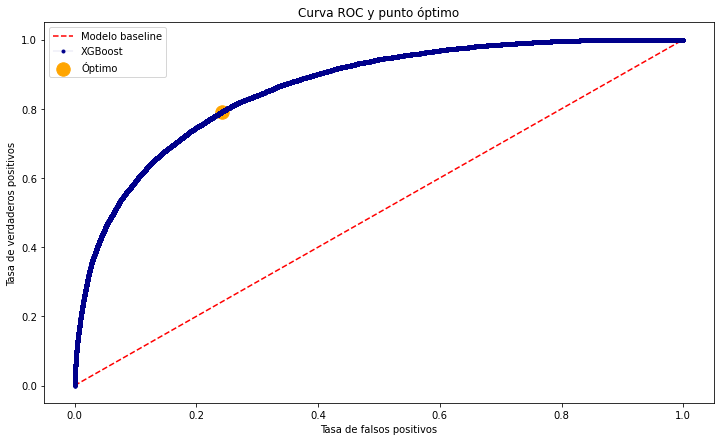

In [18]:
plt.figure(figsize=(12, 7))

# Hacemos los plots
plt.plot([0,1], [0,1], # es simplemente una linea recta en diagonal 
         linestyle='--', # linea punteada
         color='red',
         label='Modelo baseline') # etiqueta de la leyenda

# Plot de la roc
plt.plot(fpr, # en el eje x, los falsos positivos
         tpr, # en el eje y, los verdaderos positivos
         marker='.',
         linewidth=0.1,
         color='darkblue',
         label='XGBoost')

# Plot del punto óptimo
plt.scatter(fpr[indice_maxima_media_geometrica], # coordenada en el eje x
            tpr[indice_maxima_media_geometrica], # coordenada en el eje y
            s=180, # tamaño
            marker='o', 
            color='orange', 
            label='Óptimo')

# Etiquetas 
plt.title('Curva ROC y punto óptimo')
plt.xlabel('Tasa de falsos positivos')
plt.ylabel('Tasa de verdaderos positivos')
plt.legend();

In [19]:
# adjust threshold explanation

In [20]:
# report evaluate_model

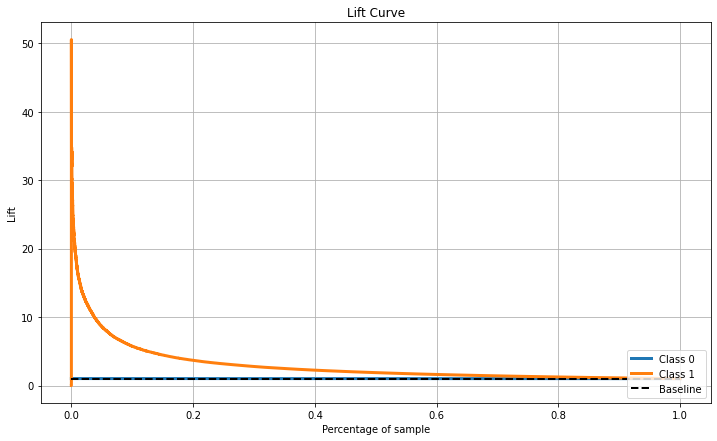

In [21]:
# lift curve
skplt.metrics.plot_lift_curve(ytest, ypred_proba, figsize=(12, 7));

In [22]:
# interpretacion

In [23]:
# importancia variables
datos_importancia_variables = clf.best_estimator_.feature_importances_

In [24]:
importancia_variables = sorted(
                              list(zip(xtest.columns, # el nombre de las variables 
                                       datos_importancia_variables)), # el valor de la importancia que tienen
    
    key=lambda tupla: tupla[1], # de cada tupla, el primer elemento
    reverse=True) # Orden de mayor a menor

importancia_variables = pd.DataFrame(importancia_variables)
importancia_variables.rename(columns={ 0: 'Variable',  1: 'Importancia'}, inplace=True)


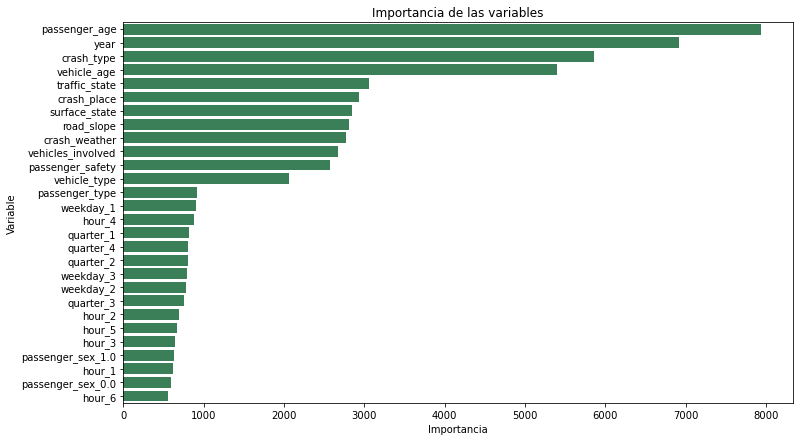

In [25]:
plt.figure(figsize=(12, 7))

sns.barplot(x='Importancia',
            y='Variable', 
            data=importancia_variables, 
            color='seagreen')

plt.title('Importancia de las variables');

In [26]:
# SHAP

In [28]:
shap.initjs()

In [29]:
model = clf.best_estimator_

In [30]:
explainer = shap.TreeExplainer(model)

In [31]:
shap_values = explainer.shap_values(xtest)

In [38]:
with open('../models/shap_values.pickle', 'wb') as f:
    pickle.dump(shap_values, f)

In [39]:
# Para no tener que ejecutar
with open('../models/shap_values.pickle', 'rb') as f:
    shap_values = pickle.load(f)

In [32]:
# una sola linea, explicada
shap.force_plot(explainer.expected_value[0], shap_values[0][149], xtest.iloc[0,:])

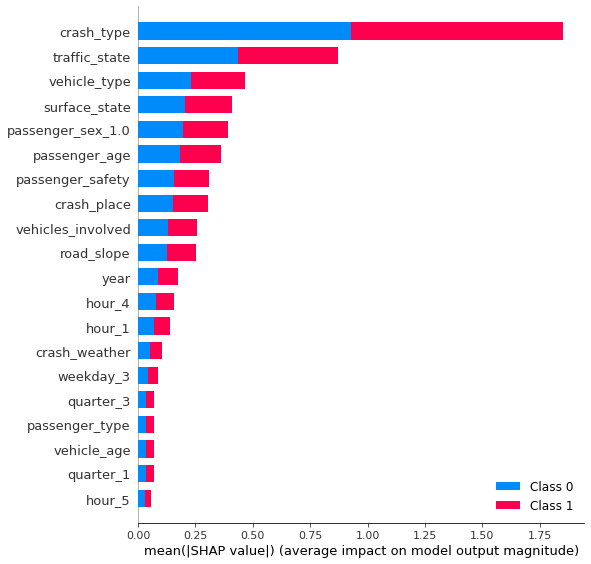

In [33]:
shap.summary_plot(shap_values, xtest)

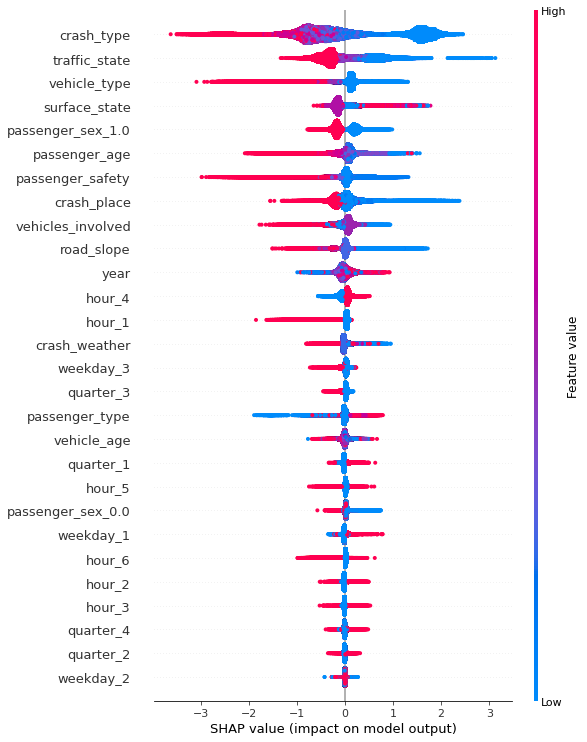

In [34]:
shap.summary_plot(shap_values[0], features=xtest, max_display=28)

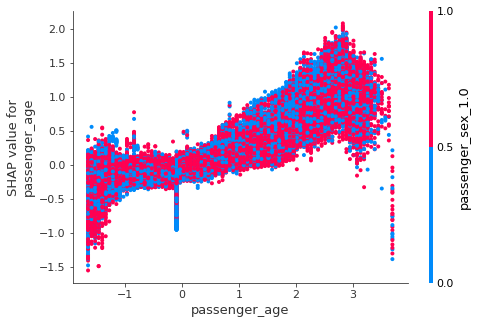

In [35]:
variable = 'passenger_age'

shap.dependence_plot(variable, shap_values[1], xtest, interaction_index="passenger_sex_1.0")